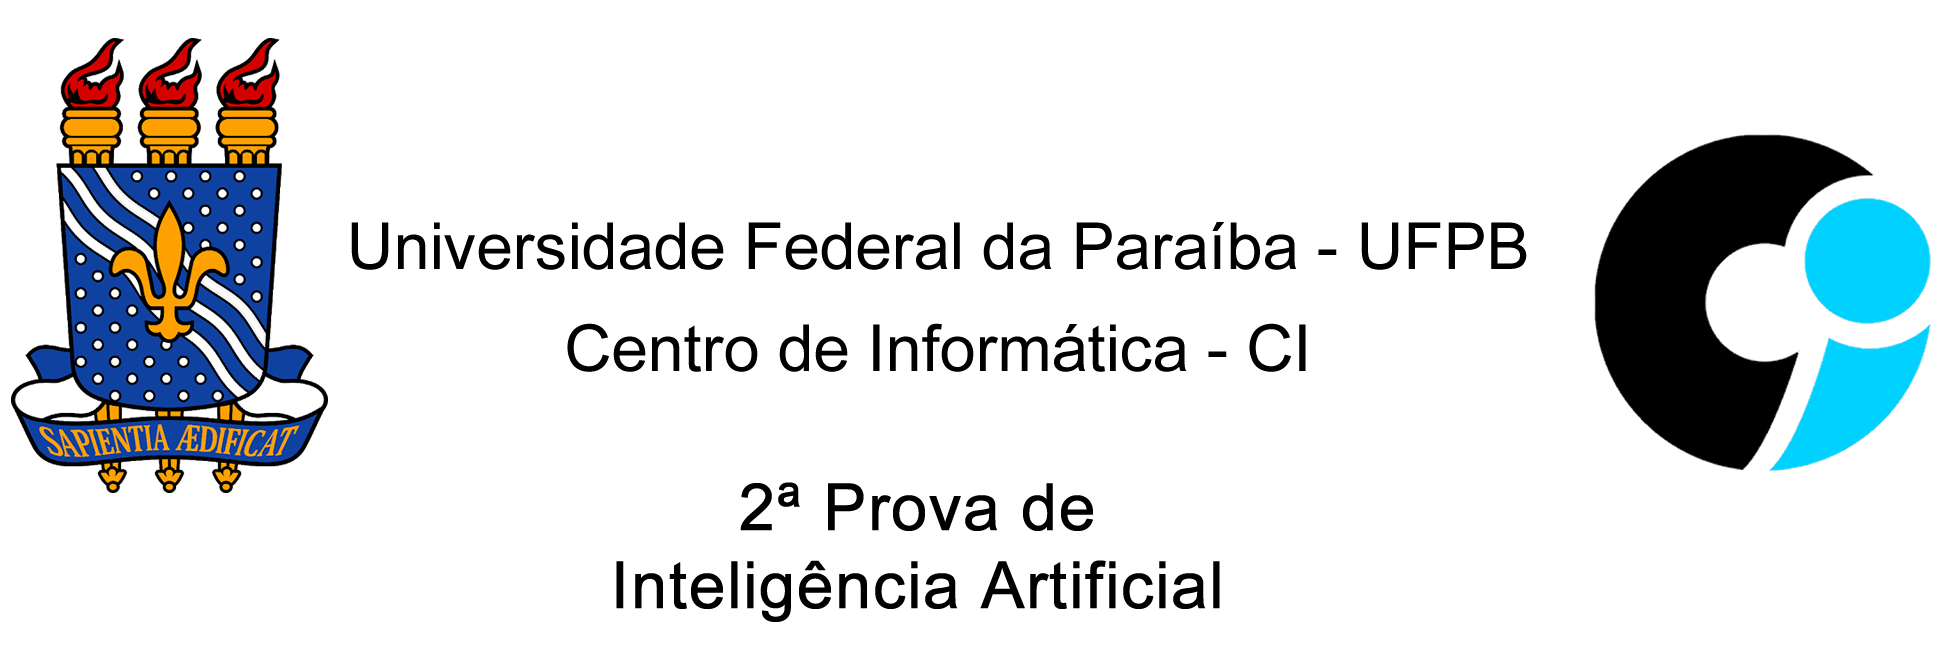

In [41]:
from IPython.display import Image
Image(filename='img/logo.fw.png', width="600px")


Aluna: Sarah Andrade Toscano de Carvalho  
Matrícula:20170022895   
Profª: Thaís Gaudencio

## Questão 1

Acessar a base de dados HCV (https://archive.ics.uci.edu/ml/datasets/HCV+data#) e desenvolver dois algoritmos supervisionados, podendo ser Redes Neurais Artificiais, Árvore de Decisão ou outros de sua escolha, para classificação entre Doador ou Não Doador, que são positivos para Hepatite C, Fibrose ou Cirrose. 

Ambos modelos devem ser analisados pelas métricas: Acurácia, Especificidade, Sensibilidade e Matriz de Confusão e os resultados devem ser discutidos. Na base consta instâncias rotuladas como Possíveis Doadores (0s=suspect Blood Donor), que devem ser classificadas separadamente após a construção dos modelos, compare os resultados obtidos em cada método utilizado.

### Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Importação da base de dados

In [3]:
dataset = pd.read_csv('./database/data-Q1.csv', delimiter=',', index_col=0)
dataset['Sex'] = dataset['Sex'].replace({'m': 0, 'f': 1})

In [4]:
dataset.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [5]:
dataset["Category"].value_counts().sort_index()

0=Blood Donor             533
0s=suspect Blood Donor      7
1=Hepatitis                24
2=Fibrosis                 21
3=Cirrhosis                30
Name: Category, dtype: int64

### Pré-processamento

#### Verificação de dados nulos

In [6]:
dataset.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [7]:
dataset=dataset.dropna()

In [8]:
dataset.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

In [9]:
dataset.query("ALP.isnull()", engine='python')

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


In [10]:
a= dataset.query("ALP.isnull()", engine='python')["Category"]
print(a.index)

Int64Index([], dtype='int64')


In [11]:
#dataset = dataset.to_numpy
#print(type(dataset))


In [12]:
#dataset = np.delete(dataset, a.index, axis=0)
#print(dataset)

In [13]:
#print(type(dataset))
#dataset = pd.Series(dataset)
#print(type(dataset))



In [14]:
#dataset = pd.DataFrame.from_records(dataset)

In [15]:
a= dataset.query("ALP.isnull()", engine='python')["Category"]


In [16]:
dataset.query("CHOL.isnull()", engine='python')

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


#### Divisão do dataset em dados de entrada (x) e de saída (y)

In [17]:
x = dataset.iloc[:, 1:].values


In [18]:
y = dataset.iloc[:, 0:1].values


In [19]:
#dimensão dos dados
x.shape

(589, 12)

#### 📈 Análise Gráfica antes do pré-processamento dos dados ausentes

In [20]:
#dataset["ALP"].plot.box(grid = True, figsize=(8,6))
#plt.title('ALP', fontsize=16)

In [21]:
#dataset["CHOL"].plot.box(grid = True, figsize=(8,6))
#plt.title('CHOL', fontsize=16)

#### Tratando dados ausentes, substituição pela mediana


In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(x[:, 2:])
x[:, 2:] = imputer.transform(x[:, 2:])


KeyboardInterrupt: 

### Codificação da Variável Dependente
→ Inicialmente todos os 4 rótulos do atributo _category_ serão codificados de string para números inteiros de 0-4, onde:
- 0: Blood Donor
- 1: Suspect Blood Donor
- 2: Hepatitis
- 3: Fibrosis
- 4: Cirrhosis


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
print(y)

→ E em seguida, é realizada uma nova análise desses novos valores com o intuito de identificar quais deles são referentes ao casos: 
- Suspect Blood Donor (-1)
- Blood Donor (0)
- No Blood Donor (1)

Nesta etapa também é realizada a indexação das posições referentes as amostras dos casos suspeitos

In [ ]:
i=0
suspect_index=[]
for i in range(0,len(y)):
    if(y[i]==1):
        y[i]=-1
        suspect_index.append(i)
    if(y[i]>=2):
        y[i]=1
print(y)

### Divisão do dataset entre casos supeitos e casos confiáveis
Com a utilização do array dos index das amostras suspeitas é realizada uma cópia dos atributos dessas amostras, as quais são armazenadas em x_suspect. E, de modo subsequente, todas os dados dos casos suspeitos são apagados do dataset x e y. 

In [ ]:
print(suspect_index)

In [ ]:
#Cópia dos dados x das amostras suspeitas para um novo array 
x_suspect=[0]*len(suspect_index)
for i in range (0, len(suspect_index)):
    x_suspect[i]=x[suspect_index[i]] #Salva os valores dos casos suspeitos em um array separado
x_suspect=np.array(x_suspect)#Converte a lista para numpy

print("X para os casos suspeitos:\n", x_suspect)

In [ ]:
#Retirada dos valores suspeitos do y
y = np.delete(y, suspect_index, axis=0)
print("Y dos doadores e não doadores:\n", y)

#Anexação do label -1 para os suspeitos
y_suspect=[-1]*len(suspect_index)
print("\nY para os casos suspeitos:\n", y_suspect)
y_suspect=np.array(y_suspect)

In [ ]:
# exclusão dos casos suspeitos do dataset confiável
x = np.delete(x, suspect_index, axis=0)
print(x)
print(len(x))

### Balanceamento dos dados

In [ ]:
unique, counts = np.unique(y, return_counts=True)
a = dict(zip(unique, counts))
#amostras mínimas [1]
print(a[0]-a[1], a[0], a[1])
a = np.arange(0,a[0]-a[1]) #array de index p deletar do x, balanceamento
x = np.delete(x, a, axis=0)
y = np.delete(y, a, axis=0)

print(len(x))
print(len(y))

In [ ]:
print(a)


### Dividindo a base confiável em amostras de treinamento e teste

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Construção da Rede Neural

In [ ]:
ann = tf.keras.models.Sequential()

### Adicionando neurônios e camadas

In [ ]:
#Camada de entrada
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

### Treinando a Rede

In [ ]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history = ann.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=10, verbose=0)

### Predição dos resultados

In [ ]:
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)


In [ ]:
### Matriz de Confusão
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)


In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
# summarize history for accuracy
print(history.history.keys())  
plt.figure(1)  

# summarize history for accuracy  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Classificação dos casos suspeitos

In [ ]:
pd.DataFrame.from_records(x_suspect)

In [ ]:
y_pred = ann.predict(np.array(x_suspect))
print(y_pred)